# Synthetic Experiment: HyperCycle

We carry out a synthetic experiment with a custom-built dataset HyperCycle to showcase that HC-MPNNs are more expressive than HR-MPNNs in the task of link prediction with relational hypergraphs. 

In [1]:
import torch
from torch.nn import functional as F   
from torch_geometric.data import Data
import random
from src.model import HC_MPNN, HR_MPNN
from src.dataset import CustomBatch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset Construction

We construct HyperCycle, a synthetic dataset that consists of multiple relational hypergraphs with relation $R = \{r_0, r_1,r_2\}$. Each relational hypergraph $G$ is parameterized by 2 hyperparameters: the number of nodes $n$ which is always a multiple of $4$, and the arity of each edge $k$. Given such $(n,k)$ pair, we generate the relational hypergraph $G(n,k) = (V,E,R)$ where
\begin{align*}
    V &= \{x_1, \cdots, x_n\} \\
    E &= \{r_{(i \bmod 2)+1}(x_{(i+j)\bmod n} \mid 0 \leq j < k) \mid 1 \leq i \leq n \} \\ 
    R &= \{r_0,r_1,r_2\}
\end{align*}

In short, there is a directed hyper-edge of arity $k$ with alternating relations between $r_1$ and $r_2$ for all $k$ consecutive nodes in this cycle. We present one example of such relational hypergraph below, where $n=8$ and $k=3$. We generate the dataset by choosing $n = \{8, 12, 16, 20\}$ and $k = \{3, 4, 5, 6, 7\}$. We then randomly pick 70\% of the generated graphs as the training set and the remaining 30\% as the testing set. 

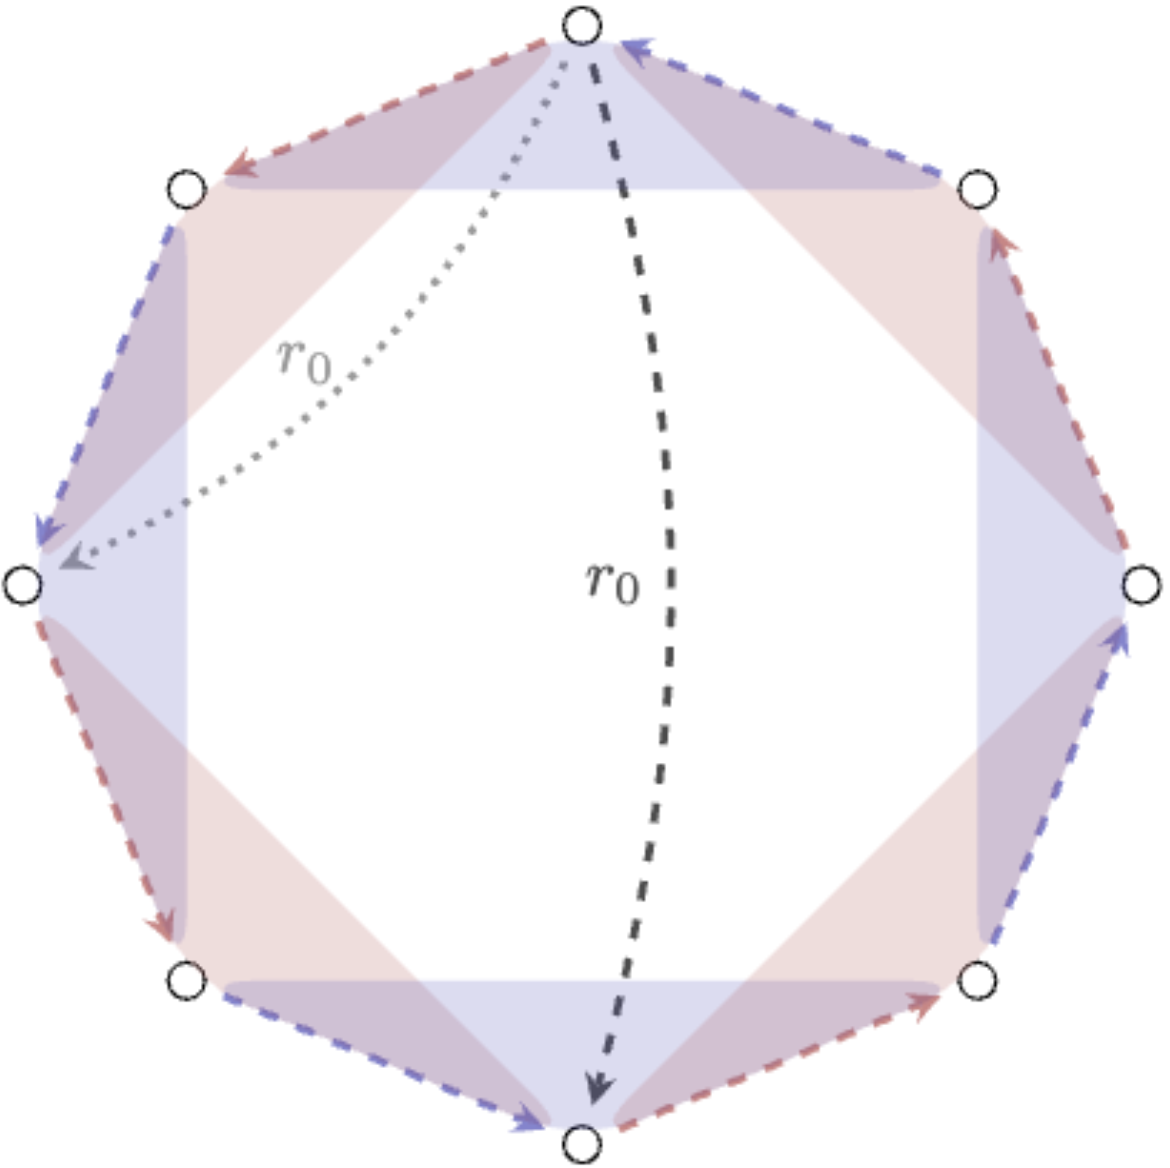


## Objective 
The objective of this task is for each node to identify the node that is located at the *opposite point*  in the cycle of the given node as true. Formally speaking, for a relational hypergraph $G(n,k)$, we want to predict a $2$-ary (hyper-)edge of relation $r_0$ between any node $x_i$ and its *opposite point* $x_{(i+n/2 \bmod n)}$ for all $1 \leq i \leq n$, i.e., classify $r_0(x_i, x_{(i+n/2)\bmod n})$ as true. The negative sample is generated by considering the $r_0$ relation (hyper-)edges that connect the ``2-hop'' neighboring node, i.e., classify $r_0(x_i, x_{(i+2)\bmod n})$ as false. Note that since $n \neq 4$, we will never have $(i+n/2)\bmod n = (i+2) \bmod n$.

# Design

We claim that HCNet can correctly predict all the testing triplets, whereas HRNet fails to learn this pattern and will only achieve $50\%$ accuracy, which is no better than random guessing. This is exactly due to the lack of expressiveness of HR-MPNNs by relying on a $k$-ary decoder for link prediction. Theoretically, all nodes of the relational hypergraphs in HyperCycle, due to their rotational symmetry introduced by alternating relation types $r_1,r_2$, can be partitioned into two sets. Since the nodes within each set are isomorphic to each other, it is impossible for any HR-MPNNs to distinguish between these nodes by only computing its unary invariant. Thus HR-MPNNs cannot possibly solve this task, as whenever they classify the target *opposite point* node to be true, they also have to classify the  *2-hop* node to be true, and vice versa. 

However, HCNet can bridge this gap by introducing the relevant notion of *distance*. As HCNet carries out message-passing after identifying the source node, the relative distance between the source node and the target *opposite point* node will be different than the one with the *2-hop* node. Thus, by keeping track of the distance from the source node, HCNet will compute a different embedding for the positive triplet and the negative triplet, effectively solving this task. 

In [3]:
def create_data_instances(n, k, max_arity=7):
    
    # Edge index is a shape of (max_arity, n), where its consecutive k elements are connected.
    index = -torch.ones((max_arity, n), dtype=torch.long)
    # Loop through each node to establish the connections
    for i in range(0, n):
        for j in range(k):
            # Connect to the next k nodes in a circular manner
            index[j, i] = (i + j) % n
    index += 1
    edge_type = torch.arange(1,3).repeat(n//2)
    
    target_edge_index = torch.zeros((2, n), dtype=torch.long)
    target_edge_index[0] = torch.arange(n)
    target_edge_index[1] = (torch.arange(n) + n/2)%n
    target_edge_index += 1 # save the bit

    not_target_edge_index = torch.zeros((2, n), dtype=torch.long)
    not_target_edge_index[0] = torch.arange(n) 
    not_target_edge_index[1] = (torch.arange(n) + 2)%n
    not_target_edge_index += 1 # save the bit

    my_batch = torch.zeros(1, 2*n, max_arity+3, dtype=torch.long)
    my_batch[:,::2,-2] = 1 # assign the positive label
    my_batch[:,:, -1] = 2 # assign the arity for each label
    my_batch[:,:,1:3] = torch.stack([target_edge_index.T, not_target_edge_index.T], dim=0).transpose(0,1).contiguous().view(-1,2)
    my_batch = my_batch.reshape(n,2,max_arity+3)
    graph = Data(
        edge_index=index.T,
        edge_type=edge_type,
        device = device,
        batch = CustomBatch(my_batch.detach().numpy())
    )
    

    return graph


In [4]:
def generate_dataloader(seed=0):
    graph_list = []
    for n in [8, 12, 16, 20]:
        for k in range(3, 8):
            graph_list.append(create_data_instances(n, k, max_arity=7))
    random.Random(seed).shuffle(graph_list)
    split = int(len(graph_list) * 0.7) # Don't do shuffling to see if this can generalize well to unseen large graphs
    train_list = graph_list[:split]
    test_list = graph_list[split:] 
    return train_list, test_list

In [5]:
def get_target_sampling(graph_data):
    target_edge_index = graph_data.target_edge_index
    target_edge_type = graph_data.target_edge_type
    not_target_edge_index = graph_data.not_target_edge_index
    not_target_edge_type = graph_data.not_target_edge_type

    h_index = torch.cat([target_edge_index[0], not_target_edge_index[0]]).unsqueeze(-1)
    t_index = torch.cat([target_edge_index[1], not_target_edge_index[1]]).unsqueeze(-1)
    r_index = torch.cat([target_edge_type, not_target_edge_type]).unsqueeze(-1)
    target = torch.zeros(h_index.size(0))
    target[: target_edge_index.size(-1)] = 1

    return torch.stack([h_index.to(torch.int64), t_index.to(torch.int64), r_index.to(torch.int64)], dim=-1), target.unsqueeze(-1)

# Training and Testing Loops

In [6]:
def train_and_validate(
    model,
    train_dataloader,
    num_epoch,
    lr,
):
    if num_epoch == 0:
        return

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    batch_id = 0
    for epoch in range(0, num_epoch):
        model.train()
        print(f"Epoch {epoch} begin")
        losses = []
        for graph_data in train_dataloader:
            graph_data.to(device)
            pred = model(graph_data.batch, graph_data.edge_index, graph_data.edge_type)
           
            label = graph_data.batch.get_label().float()
            target = torch.tensor(label,dtype=torch.float64).to(device)
            loss = F.binary_cross_entropy_with_logits(pred, target).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            batch_id += 1
        avg_loss = sum(losses) / len(losses)
        print("Epoch %d end" % epoch)
        print("average binary cross entropy: %g" % avg_loss)

In [7]:
@torch.no_grad()
def test(model, test_dataloader):
    model.eval()
    corrects = []
    totals = []
    for graph_data in test_dataloader:
        graph_data.to(device)
        pred = model(graph_data.batch, graph_data.edge_index, graph_data.edge_type)
        target = graph_data.batch.get_label().float()
        target =  torch.tensor(target,dtype=torch.float64).to(device)
        output = (F.sigmoid(pred) > 0.5).float()
        correct = (output == target).float().sum()
        corrects.append(correct)
        totals.append(target.numel())
    accuracy = 100 * sum(corrects) / sum(totals)
    print("Accuracy = {}".format(accuracy))
    return accuracy

In [8]:
train_dataloader, test_dataloader = generate_dataloader()

# Model Definitions

We considered two model architectures, namely an HC-MPNN instance HCNet:
\begin{align*}
\mathbf{h}_{v|\mathbf{q}}^{(0)} &= \sum_{i \neq t} \mathbb{1}_{v = u_i} *(\mathbf{p}_{i} + \mathbf{z}_q ) \\
\mathbf{h}_{v|\mathbf{q}}^{(\ell+1)}  &= \sigma\Big( \mathbf{W}^{(\ell)} \Big[\mathbf{h}_{v|\mathbf{q}}^{(\ell)} \Big\| \sum_{(e,i) \in E(v) } \Big(\odot_{j \neq i}(\alpha^{(\ell)}\mathbf{h}_{e(j)|\mathbf{q}}^{(\ell)} + (1-\alpha^{(\ell)})\mathbf{p}_{j})\odot\mathbf{y}_r^{(\ell)}   \Big) \Big] + \mathbf{b}^{(\ell)} \Big). 
\end{align*}


and a corresponding HR-MPNN instance called *HRNet* that shares the same *update*, *aggregate*, and relation-specific *message* functions as in *HCNet*, defined as follow:

\begin{align*}
\mathbf{h}_{v}^{(0)} &= \mathbf{1}^d \\
\mathbf{h}_{v}^{(\ell+1)}  &= \sigma\Big( \mathbf{W}^{(\ell)} \Big[\mathbf{h}_{v}^{(\ell)} \Big\| \sum_{(e,i) \in E(v) } \Big(\odot_{j \neq i}(\alpha^{(\ell)}\mathbf{h}_{e(j)}^{(\ell)} + (1-\alpha^{(\ell)})\mathbf{p}_{j})\odot\mathbf{y}_r^{(\ell)}   \Big) \Big] + \mathbf{b}^{(\ell)} \Big). 
\end{align*}

In [12]:
HCMPNN = HC_MPNN(
    hidden_dims = 32, 
    num_nodes = 20, # max number of n
    num_relation = 3, 
    num_layer = 7,
    dropout=0,
    max_arity=7,
).to(device)

HRMPNN = HR_MPNN(
    hidden_dims = 32, 
    num_nodes = 20, # max number of n
    num_relation = 3, 
    num_layer = 7,
    dropout=0, 
    max_arity=7,
).to(device)

# Experiments

For both models, we use $7$ layers, each with $32$ hidden dimensions. We configure the learning rate to be 1e-3 for both models and train them for 100 epochs. Empirically, we observe that HCNet easily reaches $100\%$ accuracy, solving this task completely, whereas HRNet always fails to learn anything meaningful, reaching an accuracy of $50\%$. The experiment results are consistent with our theory. 

In [13]:
train_and_validate(
    HCMPNN,
    train_dataloader,
    num_epoch=100,
    lr=0.001,
)
test(HCMPNN, test_dataloader)

Epoch 0 begin


/tmp/ipykernel_3154091/2576417286.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label,dtype=torch.float64).to(device)


Epoch 0 end
average binary cross entropy: 0.685795
Epoch 1 begin
Epoch 1 end
average binary cross entropy: 0.637414
Epoch 2 begin
Epoch 2 end
average binary cross entropy: 0.560414
Epoch 3 begin
Epoch 3 end
average binary cross entropy: 0.427321
Epoch 4 begin
Epoch 4 end
average binary cross entropy: 0.347029
Epoch 5 begin
Epoch 5 end
average binary cross entropy: 0.310361
Epoch 6 begin
Epoch 6 end
average binary cross entropy: 0.269107
Epoch 7 begin
Epoch 7 end
average binary cross entropy: 0.18862
Epoch 8 begin
Epoch 8 end
average binary cross entropy: 0.145519
Epoch 9 begin
Epoch 9 end
average binary cross entropy: 0.127433
Epoch 10 begin
Epoch 10 end
average binary cross entropy: 0.167436
Epoch 11 begin
Epoch 11 end
average binary cross entropy: 0.106647
Epoch 12 begin
Epoch 12 end
average binary cross entropy: 0.0965714
Epoch 13 begin
Epoch 13 end
average binary cross entropy: 0.0842358
Epoch 14 begin
Epoch 14 end
average binary cross entropy: 0.0808174
Epoch 15 begin
Epoch 15 end

/tmp/ipykernel_3154091/2121313688.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target =  torch.tensor(target,dtype=torch.float64).to(device)


tensor(100., device='cuda:0')

In [11]:
train_and_validate(
    HRMPNN,
    train_dataloader,
    num_epoch=100,
    lr=0.001,
)
test(HRMPNN, test_dataloader)

Epoch 0 begin


/tmp/ipykernel_3154091/2576417286.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label,dtype=torch.float64).to(device)


Epoch 0 end
average binary cross entropy: 0.698676
Epoch 1 begin
Epoch 1 end
average binary cross entropy: 0.694115
Epoch 2 begin
Epoch 2 end
average binary cross entropy: 0.693958
Epoch 3 begin
Epoch 3 end
average binary cross entropy: 0.693847
Epoch 4 begin
Epoch 4 end
average binary cross entropy: 0.693787
Epoch 5 begin
Epoch 5 end
average binary cross entropy: 0.69377
Epoch 6 begin
Epoch 6 end
average binary cross entropy: 0.693705
Epoch 7 begin
Epoch 7 end
average binary cross entropy: 0.693594
Epoch 8 begin
Epoch 8 end
average binary cross entropy: 0.693528
Epoch 9 begin
Epoch 9 end
average binary cross entropy: 0.693552
Epoch 10 begin
Epoch 10 end
average binary cross entropy: 0.693621
Epoch 11 begin
Epoch 11 end
average binary cross entropy: 0.693625
Epoch 12 begin
Epoch 12 end
average binary cross entropy: 0.693525
Epoch 13 begin
Epoch 13 end
average binary cross entropy: 0.693455
Epoch 14 begin
Epoch 14 end
average binary cross entropy: 0.693473
Epoch 15 begin
Epoch 15 end
av

/tmp/ipykernel_3154091/2121313688.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target =  torch.tensor(target,dtype=torch.float64).to(device)


tensor(50., device='cuda:0')